# Sprint
## ディープラーニングフレームワーク2

## 1.このSprintについて

### Sprintの目的
- フレームワークのコードを読めるようにする
- フレームワークを習得し続けられるようになる
- 理論を知っている範囲をフレームワークで動かす

### どのように学ぶか
前半はTensorFlowのExampleを動かします。後半ではKerasのコードを書いていきます。

## 2.公式Example

深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

### 【問題1】
#### 公式チュートリアルモデルを分担して実行
TensorFLowの公式チュートリアルモデルを分担して実行してください。


以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。


[models/tutorials at master · tensorflow/models](https://www.tensorflow.org/tutorials)

### 【問題2】
#### （アドバンス課題）様々な手法を実行
TensorFLowやGoogle AI ResearchのGitHubリポジトリには、定番のモデルから最新のモデルまで多様なコードが公開されています。これらから興味あるものを選び実行してください。


なお、これらのコードは初学者向けではないため、巨大なデータセットのダウンロードが必要な場合など、実行が簡単ではないこともあります。そういった場合は、コードリーディングを行ってください。


[models/research at master · tensorflow/models]()


[google-research/google-research: Google AI Research]()


更新日が古いものはPythonやTensorFlowのバージョンが古く、扱いずらい場合があります。新しいものから見ることを推奨します。

## 3.異なるフレームワークへの書き換え

「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。


- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
- Iris（3種類全ての目的変数を使用して多値分類）
- House Prices
- MNIST

### Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。


KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

### 【問題3】
#### Iris（2値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [1]:
# dataset読み込み
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df_iris = pd.read_csv('Iris.csv')
display(df_iris)
X = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 1:5])
y = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 5])
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
display(X.shape)
display(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


(100, 4)

(100, 1)

(64, 4) (64, 1)
(16, 4) (16, 1)
(20, 4) (20, 1)


In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(5, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.03),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 64 samples, validate on 16 samples
Epoch 1/10
64/64 [==============================] - 0s 3ms/sample - loss: 0.2196 - acc: 0.8906 - val_loss: 0.2782 - val_acc: 0.9375
Epoch 2/10
64/64 [==============================] - 0s 2ms/sample - loss: 0.1102 - acc: 0.9531 - val_loss: 0.0520 - val_acc: 0.9375
Epoch 3/10
64/64 [==============================] - 0s 1ms/sample - loss: 0.0216 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9375
Epoch 4/10
64/64 [==============================] - 0s 1ms/sample - loss: 0.0182 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 1.0000
Epoch 5/10
64/64 [==============================] - 0s 1ms/sample - loss: 0.0107 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 6/10
64/64 [==============================] - 0s 1ms/sample - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 7/10
64/64 [==============================] - 0s 1ms/sample - lo

In [5]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print("y_test", y_test.flatten())

y_pred_proba [6.4849854e-05 1.0000000e+00 1.2874603e-05 1.0000000e+00 9.9999893e-01
 1.0000000e+00 2.6524067e-06 9.9940616e-01 1.0000000e+00 9.9999988e-01
 9.9999976e-01 9.9999952e-01 1.0000000e+00 2.1427870e-05 0.0000000e+00
 0.0000000e+00 8.4431535e-01 0.0000000e+00 9.9973124e-01 2.0861626e-07]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


### 【問題4】
#### Iris（多値分類）をKerasで学習
TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [6]:
# 抽出
X = np.array(df_iris.iloc[:, 1:5])
y = np.array(pd.get_dummies(df_iris.iloc[:, 5]))
y = y.astype(np.int)
display(X.shape)
display(y.shape)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(150, 4)

(150, 3)

(96, 4) (96, 3)
(24, 4) (24, 3)
(30, 4) (30, 3)


In [7]:
# モデル構築
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))
model.summary()

# コンパイル
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.03),
              metrics=['accuracy'])

# 学習
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 1,543
Trainable params: 1,543
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 0s 2ms/sample - loss: 0.5803 - acc: 0.7708 - val_loss: 0.3735 - val_acc: 0.7500
Epoch 2/10
96/96 [==============================] - 0s 1ms/sample - loss: 0.2276 - acc: 0.9167 - val_loss: 0.6959 - val_acc: 0.7917
Epoch 3/10
96/96 [==============================] - 0s 1ms/sample - loss: 0.

In [9]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print("y_test", np.argmax(y_test, axis=1))

y_pred_proba [[1.04564852e-27 2.32908914e-09 1.00000000e+00]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [1.00000000e+00 7.43522355e-09 1.46612967e-14]
 [1.41976076e-16 3.60058766e-05 9.99963999e-01]
 [9.99997854e-01 2.09982340e-06 2.25637321e-11]
 [1.10057165e-36 2.42372691e-13 1.00000000e+00]
 [9.99999046e-01 9.90514081e-07 9.72723378e-12]
 [6.84147747e-03 9.60981131e-01 3.21774036e-02]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [7.43509781e-06 6.58998191e-01 3.40994388e-01]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [7.77879078e-03 9.61717963e-01 3.05032376e-02]
 [9.35985427e-03 9.62412775e-01 2.82273069e-02]
 [9.99990702e-01 9.34896616e-06 1.59446206e-10]
 [5.44016343e-03 9.59187508e-01 3.53723243e-02]
 [1.21489335e-02 9.62576985e-01 2.52740923e-02]
 [9.99958277e-01 4.17144438e-05 1.29728839e-09]
 [9.99999762e-01 1.79668831e-07 1.11983513e-12]
 [1.25000980e-16 6.12623408

### 【問題5】
#### House PricesをKerasで学習
TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [10]:
# 読み込み
df_price = pd.read_csv('train.csv')
display(df_price)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [91]:
# 抽出
X = df_price[['LotArea', 'GrLivArea', 'YearBuilt']].values
y = df_price['SalePrice'].values[:, np.newaxis]
display(X.shape)
display(y.shape)

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 対数変換
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1460, 3)

(1460, 1)

(934, 3) (934, 1)
(234, 3) (234, 1)
(292, 3) (292, 1)


In [92]:
# モデル構築
K.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1))
model.summary()

# コンパイル
model.compile(loss='mean_squared_error',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              metrics=['mae'])

# 学習
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 120us/sample - loss: 148.6039 - mean_absolute_error: 12.1852 - val_loss: 146.2253 - val_mean_absolute_error: 12.0872
Epoch 2/100
934/934 [==============================] - 0s 51us/sample - loss: 145.8117 - mean_absolute_error: 12.0695 - val_loss: 143.9844 - val_mean_absolute_error: 11.

In [93]:
y_pred_log = model.predict(X_test)
print("y_pred_log", y_pred_log.flatten()[:5])
print("y_test", y_test.flatten()[:5])
from sklearn.metrics import mean_absolute_error
print("mae", mean_absolute_error(y_test, y_pred_log))

y_pred_log [11.978668 11.850881 11.771934 12.224342 11.689271]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]
mae 0.1888617944170851


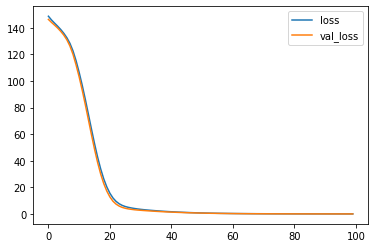

In [94]:
import matplotlib.pyplot as plt
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### 【問題6】
#### MNISTをKerasで学習
TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [105]:
# 読み込み
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float)[:, :, :, np.newaxis]
X_test = X_test.astype(np.float)[:, :, :, np.newaxis]
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


In [107]:
y_train = np.identity(10)[y_train]
y_val = np.identity(10)[y_val]
y_test = np.identity(10)[y_test]
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 10)
(12000, 10)
(10000, 10)


### 【問題7】
#### （アドバンス課題）PyTorchへの書き換え
4種類の問題をPyTorchに書き換えてください。

Keras: (N, H, W, C)

PyTorch: (N, C, H, W)

In [116]:
# 【問題3】Iris（2値分類）
## 読み込み
df_iris = pd.read_csv('Iris.csv')
display(df_iris)
X = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 1:5])
y = np.array(df_iris[(df_iris['Species'] == 'Iris-versicolor')|(df_iris['Species'] == 'Iris-virginica')].iloc[:, 5])
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
display(X.shape)
display(y.shape)

## 分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

## 標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


(100, 4)

(100, 1)

(64, 4) (64, 1)
(16, 4) (16, 1)
(20, 4) (20, 1)


In [120]:
# PyTorchでモデル構築
import torch
import torch.nn as nn

n_features = 4
n_nodes_1 = 10
activation_1 = nn.ReLU()
n_nodes_2 = 5
activation_2 = nn.ReLU()
n_output = 1
activation_output = nn.Sigmoid()

## ネットワーク
class NNfor2(nn.Module):
    
    def __init__(self):
        super(NNfor2, self).__init__()
        self.layer_1 = nn.Linear(
            n_features,
            n_nodes_1)
        self.layer_2 = nn.Linear(
            n_nodes_1,
            n_nodes_2)
        self.layer_output = nn.Linear(
            n_nodes_2,
            n_output)
    
    def forward(self, X):
        X = activation_1(self.layer_1(X))
        X = activation_2(self.layer_2(X))
        X = activation_output(self.layer_output(X))

        return X

## インスタンス作成
model = NNfor2()
print(model)

NNfor2(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=5, bias=True)
  (layer_output): Linear(in_features=5, out_features=1, bias=True)
)


In [125]:
## ミニバッチ
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1

## numpy配列をテンソルに変換
t_X_train = torch.from_numpy(X_train).float()
t_y_train = torch.from_numpy(y_train).float()
t_X_valid = torch.from_numpy(X_val).float()
t_y_valid = torch.from_numpy(y_val).float()

## 特徴量とラベルをデータセットにまとめる
dataset_train = TensorDataset(t_X_train, t_y_train)
dataset_valid = TensorDataset(t_X_valid, t_y_valid)

# データローダを作成
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [121]:
## オプティマイザ
import torch.optim as optim

lr = 0.003

optimizer = optim.Adam(
    model.parameters(),
    lr=lr
)

## 損失関数
criterion = nn.BCELoss()

In [123]:
## 学習(train)
def train_step(X_train, y_train):
    ## 訓練モード    
    model.train()

    ## 訓練データに対して予測
    y_train_pred = model(X_train)

    ## 勾配初期化
    optimizer.zero_grad()
    ## 損失の取得
    loss = criterion(y_train_pred, y_train)
    ## 勾配を計算
    loss.backward()

    ## パラメータ更新
    optimizer.step()

    ## 正解率の確認
    with torch.no_grad():
        y_train_pred_binary = np.where(y_train_pred>0.5, 1, 0)
        acc = (y_train_pred_binary == y_train).sum()

    return (loss.item(), acc.item())

## 評価(validation)
def valid_step(X_val, y_val):
    ## 評価モード
    model.eval()

    ## 予測
    y_val_pred = model(X_val)

    ## 損失計算
    loss = criterion(y_val_pred, y_val)

    ## 正解率計算
    with torch.no_grad():
        y_val_pred_binary = np.where(y_val_pred>0.5, 1, 0)
        acc = (y_val_pred_binary == y_val).sum()

    return (loss.item(), acc.item())

In [ ]:
## パラメータ初期化関数
def initializer(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight)
        layer.bias.data.fill(0.0)

## パラメータ初期化する
model.apply(initializer)

n_epoch = 10
train_history = []
val_history = []

avg_loss = 0.0
avg_acc = 0.0
avg_val_loss = 0.0
avg_val_acc = 0.0

## 学習する
for epoch in range(n_epoch):
    ## epoch内のloss, accの保存
    total_loss = 0.0
    total_acc = 0.0
    total_val_loss = 0.0
    total_val_acc = 0.0
    ## 累計データ数の保存
    total_train = 0
    total_val = 0

    ## 訓練
    for X_train, y_train in loader_train:
       loss, acc = train_step(X_train, y_train)
       total_loss += loss
       total_acc += acc
       total_train += len(y_train)

    ## 評価
    for X_val, y_val in loader_valid:
        val_loss, val_acc = valid_step(X_val, y_val)
        total_val_loss += val_loss
        total_val_acc += val_acc
        total_val += len(y_val)

    n = epoch+1
    avg_loss = total_loss/n
    avg_val_loss = total_val_loss/n
    avg_acc = total_acc/total_train
    avg_val_acc = total_val_acc/total_val

    

### 【問題8】
#### （アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。


**《視点例》**


- 計算速度
- コードの行数・可読性
- 用意されている機能